<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#GDN" data-toc-modified-id="GDN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>GDN</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



In [7]:
fp1 = "../figures/activation_fns.png"
fp2 = "../figures/GDN.png"
sns.set()
sns.set_style("whitegrid")

In [8]:


def sigmoid(x): 
    return 1 / (1 + np.exp(-x))
def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    #x = x.reshape((-1, 1))
    #zero = np.zeros_like(x)
    #inp = np.concatenate([zero, x], axis=1)
    return np.maximum(x, 0)
def relu_grad(x):
    res = x.copy()
    res[x <= 0] = 0
    res[x >= 0] = 1
    return res

def Prelu(x, alpha=0.15):
    res = x.copy()
    res[x <= 0] = alpha * res[x <= 0]
    
#     x = x.reshape((-1, 1))
#     ones = np.ones_like(x)
#     inp = np.concatenate([ones * alpha, x], axis=1)
    return res

    return np.max(alpha*x, x, axis=0)
def Prelu_grad(x, alpha=0.15):
    res = (x > 0).astype(int)
    result = np.maximum(alpha, res)
    return result


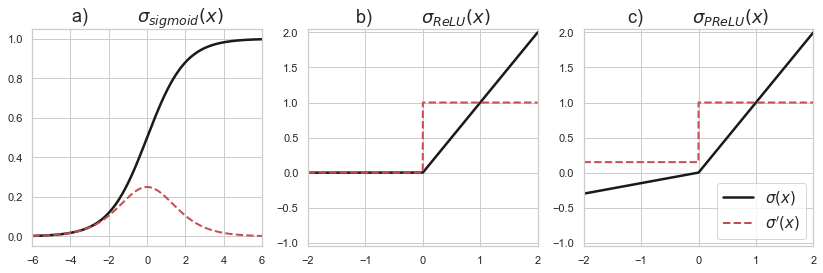

In [9]:
#plot for first 3 activations first
# create data
rr = np.arange(-7, 7, 0.001)
epsilon = 0.05

fig, axs = plt.subplots(1,3, sharey=False)
fig.set_size_inches(14, 4)

fns = [(sigmoid, sigmoid_grad), (relu, relu_grad), (Prelu, Prelu_grad)]
xlims = [(-6, 6), (-2, 2), (-2, 2)]
ylims = [(0, 1), (-1, 2), (-1, 2)]

titles = {0: r"a)          $\sigma_{sigmoid}(x)$",
         1:  r"b)          $\sigma_{ReLU}(x)$",
         2:  r"c)          $\sigma_{PReLU}(x)$"}
for idx, ax in enumerate(axs.flatten()):
    fn, grad = fns[idx]
    
    ax.plot(rr, fn(rr), 'k-', lw=2.5)
    ax.plot(rr, grad(rr), 'r--', lw=2)
    xlim = xlims[idx]
    ax.set_xlim((xlim[0], xlim[1]))
    ylim = ylims[idx]
    ax.set_ylim((ylim[0]- epsilon, ylim[1] + epsilon))
    #ax.grid(True)
    
    #ax.set_title(idx)
    ax.set_title(titles[idx], fontsize=18)
    
plt.legend(labels=[r"$\sigma(x)$", r"$\sigma'(x)$"], loc=4, prop={'size': 15})
plt.savefig(fp1)

### GDN

In [10]:
def GDN(x, theta):
    (beta, epsi, H, alpha, gamma) = theta
    z = H * x
    denom = (beta + gamma * np.abs(z)**alpha)**epsi
    return z / denom

def GDN_grad(x, theta):
    """See http://arxiv.org/abs/1511.06281. 
    This is only correct for 1D input"""
    
    (beta, epsi, H, alpha, gamma) = theta
    z = H * x
    denom = (beta + gamma * np.abs(z)**alpha)**epsi
    A = 1 / denom
    denom2 = (beta + gamma * np.abs(z)**alpha)**(epsi + 1)
    B = alpha * gamma * epsi * z * np.abs(z) **(alpha - 1) * np.sign(z) / denom2
    
    return A - B
def GDN_grad_approx(x, theta, Eps=0.00001):
    """Use finite difference"""
    x2 = x + Eps
    x1 = x - Eps
    y2 = GDN(x2, theta)
    y1 = GDN(x1, theta)
    
    grad = (y2 - y1) / (x2 - x1)
    
    return grad

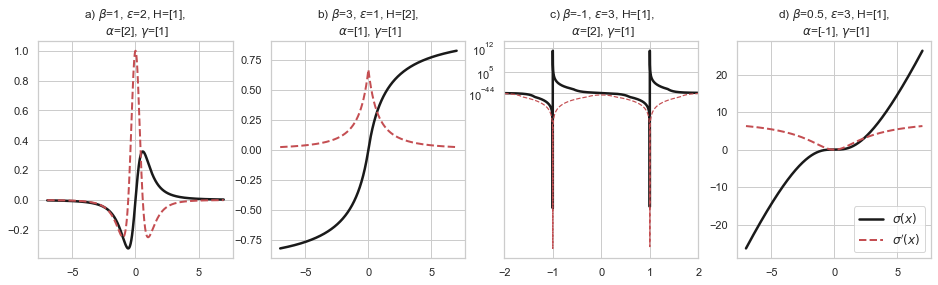

In [12]:

#(beta, epsi, H, alpha, gamma)

t1 = (1, 2, 1, 2, 1)
t2 = (3, 1, 2, 1, 1)
t3 = (-1, 3, 1, 2, 1)
t4 = (0.5, 3, 1, -1, 1)

rr = np.arange(-7, 7, 0.0001)



thetas = [t1, t2, t3, t4]

fig, axs = plt.subplots(1,len(thetas), sharey=False)
fig.set_size_inches(16, 4)

xlims = [(-6, 6), (-2, 2), (-2, 2)]
ylims = [(0, 1), (-1, 2), (-1, 2)]
titles = {0: 'a)', 1: 'b)', 2: 'c)', 3: 'd)'}
plot_grad = (1, 1, 1, 1)
y_log = (0, 0, 1, 0)
y_eps = (0, 0, 1, 0)


for idx, ax in enumerate(axs.flatten()):
    theta = thetas[idx]
    
    ax.plot(rr, GDN(rr, theta), 'k-', lw=2.5)
    
    lw = 2
    
    if y_log[idx]:
        ax.set_yscale('symlog')
        #ax.set_ylim((1e-30, 1e35))
        ax.set_xlim((-2, 2))
        
    if plot_grad[idx]:
        if y_eps[idx]:
            eps = 0.0010001
            ax.plot(rr, GDN_grad(rr, theta), 'r--', lw=1.2)
            ax.set_yticks([ 1e-44, 1e5, 1e12])
            
        else:
            ax.plot(rr, GDN_grad_approx(rr, theta), 'r--', lw=lw)
            
        
    title = r"{} {}={}, {}={}, {}=[{}]," + "\n" + r" {}=[{}], {}=[{}]"
    title_tuple = (titles[idx], r"$\beta$", theta[0], r"$\epsilon$", theta[1])
    title_tuple += (r"H", theta[2], r"$\alpha$", theta[3], r"$\gamma$", theta[4])
    title = title.format(*title_tuple)
    ax.set_title(idx)
    ax.set_title(title, fontsize=12)
    

plt.legend(labels=[r"$\sigma(x)$", r"$\sigma'(x)$"], loc= 4, prop={'size': 12})
        
plt.savefig(fp2)

